In [1]:
from copy import deepcopy

from matplotlib import pyplot as plt
import numpy as np

from deeptime.clustering import BoxDiscretization
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.data import prinz_potential
from sklearn.model_selection import ShuffleSplit
import seaborn as sns

In [2]:
def gmrq(train_msm, test_dtraj, dim, r, lag): 
    
    # find  common states
    test_cm = TransitionCountEstimator(lagtime=lag, count_mode='sliding').fit_fetch(test_dtraj)
    common_symbols = set(train_msm.count_model.state_symbols).intersection(test_cm.state_symbols)
    common_states = train_msm.count_model.symbols_to_states(common_symbols)

    # derive test count matrix and MSM on common states 
    c0t_test = np.zeros((train_msm.n_states, train_msm.n_states), dtype=train_msm.transition_matrix.dtype)
    common_states_cm = test_cm.symbols_to_states(common_symbols)
    c0t_test[np.ix_(common_states, common_states)] = test_cm.count_matrix[np.ix_(common_states_cm, common_states_cm)]
    test_msm = MaximumLikelihoodMSM(lagtime=lag).fit_from_counts(c0t_test).fetch_model()
    
    assert np.allclose(train_msm.eigenvalues(k=dim), np.sort(train_msm.eigenvalues(k=dim))[::-1])
    
    # Calculate score
    # https://github.com/msmbuilder/msmbuilder/blob/515fd5c27836c797692d600216b5eb224dfc1c5d/msmbuilder/msm/msm.py
    V = train_msm.eigenvectors_right(k=dim)
    S = np.diag(test_msm.stationary_distribution)
    C = S.dot(test_msm.transition_matrix)
    
    R = (V.T.dot(C.dot(V)).dot(np.linalg.inv(V.T.dot(S.dot(V)))))**r
    result = np.trace(R)
    
    return result

def discretize(train_data, n_clusters, test_data=None): 
        # Discretize
    try:
        v0, v1 = np.concatenate(train_data).min(), np.concatenate(train_data).max()
        cmod = BoxDiscretization(dim=1, n_boxes=n_clusters, 
                                    v0=[v0], v1=[v1])
        
        cluster = cmod.fit_fetch(np.concatenate(train_data))
        train_dtraj = [cluster.transform(x) for x in train_data]
    except Exception as e: 
        print(v0, v1, n_clusters)
        print(e)
        
    if test_data is not None:
        test_dtraj = [cluster.transform(x) for x in test_data]    
    else: 
        test_dtraj = None
        
    return train_dtraj, test_dtraj
    
    
def score(train_dtraj, test_dtraj=None, dim=2, r=2, method='vamp',lag=2):
    mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(train_dtraj)
    
    use_cv = test_dtraj is not None
    
    if not use_cv: 
        test_dtraj = deepcopy(train_dtraj)
    try: 
        if method.lower() =='vamp': 
            result = mod.score(test_dtraj, dim=dim, r=r)
        elif method.lower() == 'gmrq': 
            result = gmrq(mod, test_dtraj, dim=dim, r=r, lag=lag)
        elif method.lower() == 'eigenvalues': 
            assert not use_cv, "can't use eigenvalues with CV method"
            result = np.sum(mod.eigenvalues(k=dim)**r)
    except: 
        result = np.nan
        
    return result
    
    
def score_cv(data, cv_splitter, n_clusters, dim=2, r=2, method='vamp',lag=2): 
    results = []
    for train_ix, test_ix in cv_splitter.split(data): 
        test_data, train_data = data[test_ix], data[train_ix]
        
        train_dtraj, test_dtraj = discretize(train_data=train_data, 
                                             test_data=test_data, 
                                             n_clusters=n_clusters)
        
        # Score
        result = score(train_dtraj, test_dtraj, dim=dim, r=r, method=method, lag=lag)
        results.append(result)
        
    return np.array(results)

def score_bootstrap(data, rng, n_iterations, n_clusters, dim=2, r=2, method='vamp', lag=2): 
    results = []
    
    ix = np.arange(len(data))
    for i in range(n_iterations):
        new_ix = rng.choice(ix, size=ix.shape[0], replace=True)
        train_data = [data[j] for j in new_ix]
        train_dtraj, _ = discretize(train_data=train_data, 
                                    test_data=None, 
                                    n_clusters=n_clusters)
        result = score(train_dtraj, dim=dim, r=r, method=method, lag=lag)
        results.append(result)
        
    return np.array(results)


def timescale_bootstrap(data, rng, n_iterations, n_clusters, dim, lag):
    results = []
    
    ix = np.arange(len(data))
    for i in range(n_iterations):
        new_ix = rng.choice(ix, size=ix.shape[0], replace=True)
        train_data = [data[j] for j in new_ix]
        train_dtraj, _ = discretize(train_data=train_data, 
                                    test_data=None, 
                                    n_clusters=n_clusters)
        mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(train_dtraj)
        result = np.array([np.nan]*(dim-1))
        for j, ts in enumerate(mod.timescales(dim-1)): 
            result[j] = ts
        
        results.append(result)

    return np.array(results)    

Parameters

In [34]:
# Data generation
n_particles = 10
n_steps = 200

# Post processing
burn_in = 1000

# Scoring parameters
lag = 2
dim=4
r=2

# Uncertainty parameters
n_iterations = 100
seed = 948398

# Scoring generators
cv = ShuffleSplit(n_splits=n_iterations, test_size=0.5, random_state=seed)
rng = np.random.default_rng(seed)

Get Data

In [35]:
prinz_system = prinz_potential()
data = prinz_system.trajectory(np.zeros((n_particles, 1)), n_steps+burn_in)
data = data[:, burn_in:, :]
N = int(data.flatten().shape[0])

In [36]:
# ref_data = prinz_system.trajectory(np.zeros((n_particles, 1)), 100000)
# ref_data = ref_data[:, burn_in:, :]
# ref_dtraj, _ = discretize(train_data=ref_data, n_clusters=100, test_data=None)
# ref_mod = MaximumLikelihoodMSM(lagtime=lag).fit_fetch(ref_dtraj)
# ref_timescales = ref_mod.timescales(4)

In [37]:
ref_timescales

array([170.9668806 ,  25.35393961,  12.93659986,   2.42358547])

In [43]:
np.round(np.array([500, 750, 1000, 2000])/ref_timescales[0])

array([ 3.,  4.,  6., 12.])

Plot data

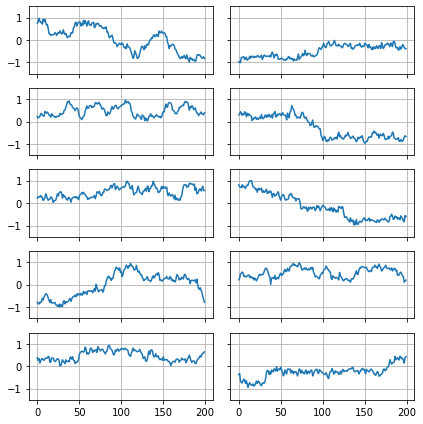

In [39]:
fig, axes = plt.subplots(5,2,  sharex=True, sharey=True, figsize=(6, 6))
for i in range(data.shape[0]):
    ax = axes.flatten()[i]
    ax.plot(data[i, :, 0].T)
    ax.set_ylim(-1.5, 1.5)
    ax.grid()
plt.tight_layout()

In [40]:
cluster_nums = np.arange(5, 51, 2).astype(int)

bs_values_vamp, bs_values_gmrq, bs_values_evs = [], [], []
cv_values_vamp, cv_values_gmrq = [], []
timescales = []
for n_clusters in cluster_nums:
    print(n_clusters)

    bs_values_vamp.append(score_bootstrap(data, rng, n_iterations, n_clusters, dim=dim, r=r, method='vamp', lag=lag))    
    cv_values_vamp.append(score_cv(data, cv, n_clusters,dim=dim, r=r, method='vamp', lag=lag))
    bs_values_gmrq.append(score_bootstrap(data, rng, n_iterations, n_clusters, dim=dim, r=r, method='gmrq', 
                                          lag=lag))    
    cv_values_gmrq.append(score_cv(data, cv, n_clusters, dim=dim, r=r, method='gmrq', lag=lag))
    timescales.append(timescale_bootstrap(data, rng, n_iterations, n_clusters, dim=dim, lag=lag))

5
7
9
11
13
15
17
19


Skipping state set [6] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


21


Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [9] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [7] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


23


Skipping state set [22] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [22] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [7] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


25


Skipping state set [24] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [24] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [8] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


27


Skipping state set [26] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [26] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [9] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..


29


Skipping state set [28] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [8] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [28] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [28] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [8] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zer

31


Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [30] due to error in estimation: Some row and corresponding column of the count matrix C have 

33


Skipping state set [15] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [32] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [32] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [32] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [32] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have z

35


Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [8] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [34] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [34] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [34] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zer

37


Skipping state set [11] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [12] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [16] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [9] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [36] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [36] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have z

39


Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [18] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [9] due to error in estimation: Some row and corresponding column of the count matrix C have 

41


Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [10] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [12] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [13] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [14] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [18] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [19] due to error in estimation: Some row and corresponding column of the count matrix C have 

43


Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [19] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [11] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [19] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [11] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have z

45


Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [20] due to error in estimation: Some row and corresponding column of the count matrix C have

47


Skipping state set [21] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [11] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [12] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [21] due to error in estimation: Some row and corresponding column of the count matrix C have ze

49


Skipping state set [23] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [22] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [26] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [12] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [22] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [46] due to error in estimation: Some row and corresponding column of the count matrix C have 

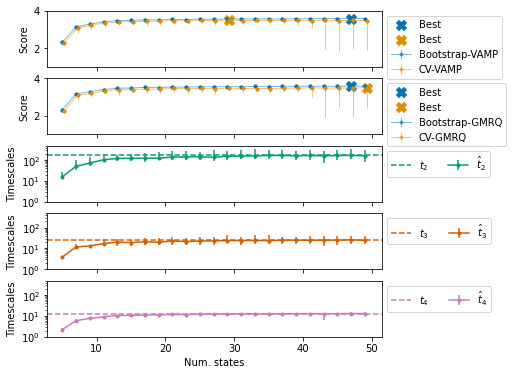

In [41]:
fig, axes = plt.subplots(5, figsize=(6, 6), sharex=True, sharey=False)

all_results = [bs_values_vamp, cv_values_vamp, bs_values_gmrq, cv_values_gmrq]
labels = ['Bootstrap-VAMP', 'CV-VAMP', 'Bootstrap-GMRQ', 'CV-GMRQ']

ms=3
cols = sns.color_palette('colorblind', 5)

for i, results in enumerate(all_results): 
    ax  = axes[i//2]
    y = np.array([np.nanmedian(result) for result in results])
    yerr = (y-np.array([np.nanquantile(result, q=0.025) for result in results]), 
            np.array([np.nanquantile(result, q=0.975) for result in results])-y)
    
    ax.errorbar(cluster_nums+(i % 2)/4, y, yerr, lw=1, elinewidth=1, marker='o', 
                label=labels[i], color=cols[i % 2], alpha=0.5, ms=ms)
    ax.errorbar(cluster_nums+(i % 2)/4, y, lw=0, marker='o', color=cols[i % 2], alpha=1, ms=ms)
    best_ix = int(np.nanargmax(y))
    ax.scatter(cluster_nums[best_ix]+(i % 2)/4, y[best_ix], marker='X', s=100, label='Best', 
              color=cols[i % 2])
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylim(1, dim)
    ax.grid()
    ax.set_ylabel('Score')

    
for i in range(dim-1):
    tmp_timescales = timescales
    ts = np.array([np.nanmedian(result, axis=0)[i] for result in tmp_timescales])
    ts_err = (ts-np.array([np.nanquantile(result, q=0.025, axis=0)[i] for result in tmp_timescales]), 
        np.array([np.nanquantile(result, q=0.975, axis=0)[i] for result in tmp_timescales])-ts)
    
    ax = axes[i+2]
    ax.errorbar(cluster_nums, ts, ts_err, label=fr'$\hat{{t}}_{{{i+2}}}$',
                     marker='o', color=cols[i+2], ms=ms)
    xlim = ax.get_xlim()
    ax.hlines(ref_timescales[i], *xlim, color=cols[i+2], ls='dashed',
                    label=fr'$t_{{{i+2}}}$', )
    ax.set_xlim(xlim)
    
    ax.set_yscale('log')
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2)
    
    ax.set_ylim(1, 500)
    ax.set_ylabel('Timescales')

axes[-1].set_xlabel('Num. states')
plt.savefig(f'timescales_vs_n_clusters_{N}.pdf', bbox_inches='tight')